In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm

pd.plotting.register_matplotlib_converters()

# Filtering


*Filtering* time series data is a process of extracting certain components or signals from the data. The idea is that time series data are the result of a collection of processes — both stochastic and deterministic — that have different *frequencies*. Many filters exist for extracting cyclical and/or trend components from business cycle data.

In this Notebook, I will show you how to use a couple of popular filters to extract business cycle components from real GDP per capita data.

## Data

Real GDP per capita data are obtained from FRED (Series ID: A939RX0Q048SBEA).

Text(0, 0.5, 'Dollars')

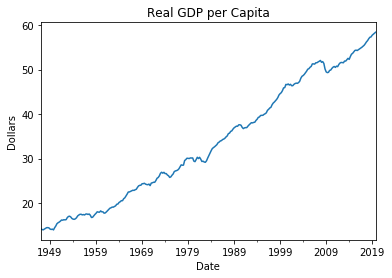

In [2]:
# Download real GDP per capita data from FRED
gdp = pd.read_csv("https://fred.stlouisfed.org/data/A939RX0Q048SBEA.txt",skiprows=14,sep='\s+',parse_dates=True,index_col=0)

# Convert units to thousands of dollars
gdp = gdp/1000

# Plot
ax = gdp.plot(legend=False,title='Real GDP per Capita')
ax.set_xlabel('Date')
ax.set_ylabel('Dollars')

In specting the data, it's apparent that there is a slow-moving (low-frequency) trend component and a cyclical (high-frequency) component. Most filters compute the cyclical component as a deviation (or diffrence) from trend. So we take the log of GDP before applying any filters. Here's why. Let $Y_t$ denote real GDP per capita and $y_t = \log Y_t$. Then if we filter $y_t$ into a trend and cyclical component,

\begin{align}
y_t & = y_t^{\text{trend}} + y_t^{\text{cycle}}
\end{align}

Since $y_t$ is the log of $Y_t$:

\begin{align}
y_t^{\text{cycle}} & = y_t - y_t^{\text{trend}}\\
& = \log Y_t - \log Y_t^{\text{trend}} \\
& \approx \frac{Y_t - Y_t^{\text{trend}}}{Y_t^{\text{trend}}}
\end{align}

Then the cyclical component of log real GDP per capita will be approximately the percentage deviation of GDP from trend (divided by 100).

Text(0, 0.5, 'log Dollars')

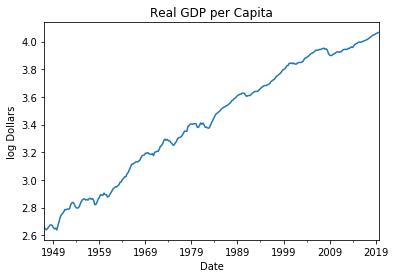

In [3]:
# Take (natural) log of GDP 
gdp = np.log(gdp)

# Plot
ax = gdp.plot(legend=False,title='Real GDP per Capita')
ax.set_xlabel('Date')
ax.set_ylabel('log Dollars')

## Linear filter

The linear filter assumes that the trend component is a linear function of time:

\begin{align}
y_t^{\text{trend}} & = \alpha_0 + \alpha_1 t
\end{align}

where $t = 0,1,2,\ldots$. To find $\alpha_0$ and $\alpha_1$, regress $y_t$ on $t$ and a constant. The predicted values of the regression will equal the estimated trend component and the residuals of the regression will equal the estimated cyclical component.

In [4]:
# Create time values
time = np.arange(0,len(gdp))

# Create X and Y variables for sm.OLS
X = sm.add_constant(time)
Y = gdp

# Create OLS model and fit
model =  sm.OLS(Y,X)
results = model.fit()

# Create variable with linear trend. Note that the results.predict() returns a
# Numpy array so I put it in a Pandas Series with the same dates as GDP.
y_trend_linear = pd.Series(results.predict(),index = gdp.index)

# Cyclical component
y_cycle_linear = results.resid

Plot trend log GDP and log GDP implied by the linear filter.

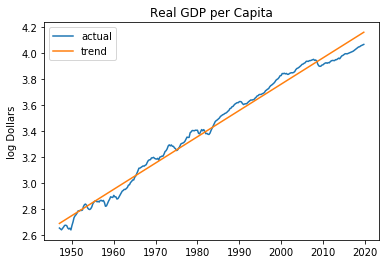

In [5]:
plt.plot(gdp,label='actual')
plt.plot(y_trend_linear,label='trend')
plt.title('Real GDP per Capita')
plt.ylabel('log Dollars')
plt.legend()

Plot the cyclical component of log GDP implied by the linear filter.

Text(0, 0.5, 'Percent')

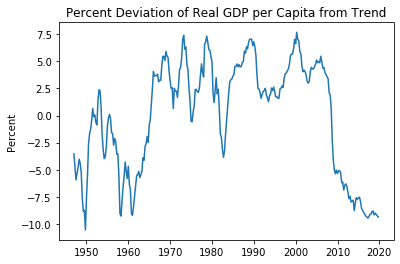

In [6]:
plt.plot(y_cycle_linear*100)
plt.title('Percent Deviation of Real GDP per Capita from Trend')
plt.ylabel('Percent')

This filter is only good if the trend is well-approximated by a linear function of time. But as you can see, according to the linear trend, there are long periods (decades) where GDP is computed to be above or below trend.

## Hodrick-Prescott Filter

The Hodrick-Prescott or HP filter is one of the most commonly used filters in macroeconomics. The HP filter doesn't assume a constant trend and instead computes the trend to minimize a complicated objective function. See: https://en.wikipedia.org/wiki/Hodrick%E2%80%93Prescott_filter.

Implement the HP filter using `statsmodels.api.tsa.filters.hpfilter()`. This function returns a trend and cyclical series.

In [7]:
# Compute the HP filter
y_cycle_hp, y_trend_hp = sm.tsa.filters.hpfilter(gdp)

Plot trend log GDP and log GDP implied by the HP filter.

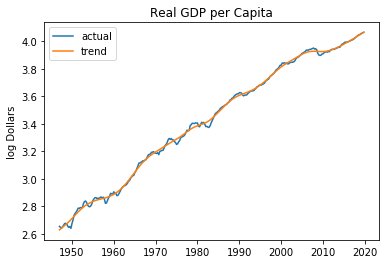

In [8]:
plt.plot(gdp,label='actual')
plt.plot(y_trend_hp,label='trend')
plt.title('Real GDP per Capita')
plt.ylabel('log Dollars')
plt.legend()

Notice how the trend computed by the HP filter has gradual movements that are not present in the trend computed with the linear filter.

Now, plot the cyclical component of log GDP implied by the HP filter.

Text(0, 0.5, 'Percent')

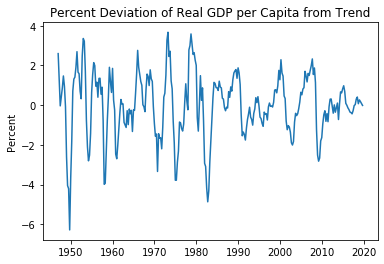

In [9]:
plt.plot(y_cycle_hp*100)
plt.title('Percent Deviation of Real GDP per Capita from Trend')
plt.ylabel('Percent')

Cyclical component of GDP computed by the HP-filter appear to return to zero more frequently than what was computed by the linear filter.

## Baxter-King or Band-Pass Filter

The Baxter-King or band-pass or BP filter is another commonly used filter in macroeconomics. The BP filter only returns a cyclical series and some data are lost at the beginning and end of the sample. See: https://en.wikipedia.org/wiki/Band-pass_filter

Implement the BP filter using `statsmodels.api.tsa.filters.bkfilter()`.

In [10]:
# Compute the BP filter
y_cycle_bp = sm.tsa.filters.bkfilter(gdp)

Plot the cyclical component of log GDP implied by the BP filter.

Text(0, 0.5, 'Percent')

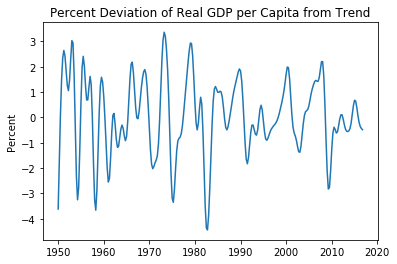

In [11]:
plt.plot(y_cycle_bp*100)
plt.title('Percent Deviation of Real GDP per Capita from Trend')
plt.ylabel('Percent')

## Comparison of the HP and BP Filters

Since the linear filter isn't very good, let's focus on comparing cyclical components of GDP computed by the HP and BP filters.

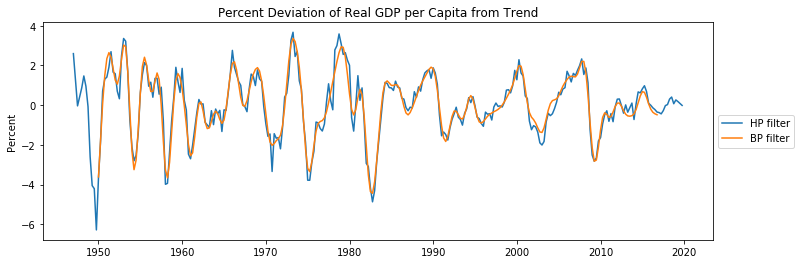

In [12]:
fig = plt.figure(figsize=(12,4))
plt.plot(y_cycle_hp*100,label='HP filter')
plt.plot(y_cycle_bp*100,label='BP filter')
plt.title('Percent Deviation of Real GDP per Capita from Trend')
plt.ylabel('Percent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

Apparently the BP filter generates a smoother series, but the results are generally comparable. It's clear that even though the functions are very different, they are computing something similar.

## Additional Notes

The default behavior for the HP and BP filter functions in statsmodels is to assume that data input are quarterly. If the data are not quarterly, then you must specify the arguments of the respective functions. Also, for data that are in terms of rates (like inflation or interest), do not take logs of the data before filtering.

In the next example, I show how to filter the business cycle component out of the monthly unemployment rate data.

Text(0, 0.5, 'Percent')

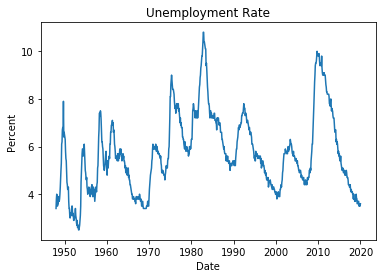

In [13]:
# Download real GDP per capita data from FRED
unemp = pd.read_csv("https://fred.stlouisfed.org/data/UNRATE.txt",skiprows=23,sep='\s+',parse_dates=True,index_col=0)

# Plot
plt.plot(unemp)
plt.title('Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Percent')

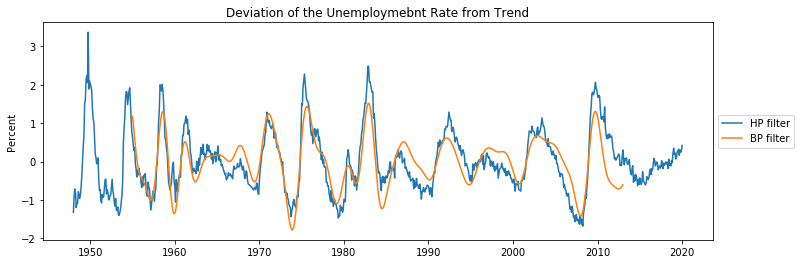

In [14]:
# Compute the HP filter
u_cycle_hp, u_trend_hp = sm.tsa.filters.hpfilter(unemp,lamb=129600)

# Compute the BP filter
u_cycle_bp = sm.tsa.filters.bkfilter(unemp,low=24,high=84,K=84)

# Plot computed cyclical components
fig = plt.figure(figsize=(12,4))
plt.plot(u_cycle_hp*1,label='HP filter')
plt.plot(u_cycle_bp*1,label='BP filter')
plt.title('Deviation of the Unemploymebnt Rate from Trend')
plt.ylabel('Percent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

An alternative to what was just done would be to resample the monthly data as quarterly data. This is often necessary anyway since most macroeconomic data are quarterly and generally all data used in statistical analysis should have the same frequency.

In [15]:
# Compute the average unemployment rate over three month windows
unempQ = unemp.resample('QS').mean()

# Verify that the dates are incremented every three months
unempQ.head()

,VALUE
DATE,
1948-01-01,3.733333
1948-04-01,3.666667
1948-07-01,3.766667
1948-10-01,3.833333
1949-01-01,4.666667


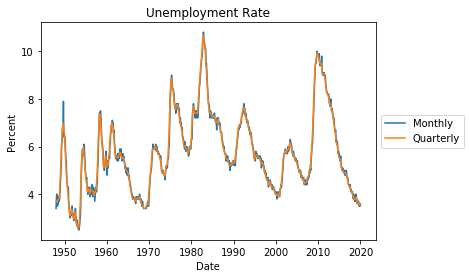

In [16]:
# Plot the quarterly and monthly series
plt.plot(unemp,label='Monthly')
plt.plot(unempQ,label='Quarterly')
plt.title('Unemployment Rate')
plt.xlabel('Date')
plt.ylabel('Percent')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))